In [9]:
import os
from pathlib import Path
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from collections import Counter

# =========================
# CONFIG / PATHS
# =========================
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
DATA_ROOT    = PROJECT_ROOT / "data"
TRAIN_DIR    = DATA_ROOT / "train"
VAL_DIR      = DATA_ROOT / "val"
TEST_DIR     = DATA_ROOT / "test"

IMG_SIZE     = 224
BATCH_SIZE   = 32   # can adjust depending on GPU RAM
NUM_WORKERS  = 2    # you used this before
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

print("📂 Dataset folders:")
print(f"   Train: {TRAIN_DIR}")
print(f"   Val:   {VAL_DIR}")
print(f"   Test:  {TEST_DIR}")
print(f"\n💻 Device detected: {DEVICE}")


📂 Dataset folders:
   Train: /home/muhammad-noman/projects/plant_disease-gpu-env/data/train
   Val:   /home/muhammad-noman/projects/plant_disease-gpu-env/data/val
   Test:  /home/muhammad-noman/projects/plant_disease-gpu-env/data/test

💻 Device detected: cuda


In [10]:
import os

def list_classes_and_counts(split_dir: Path):
    """
    Returns:
      classes: sorted list of class folder names
      counts: dict[class_name] = number_of_images
    """
    if not split_dir.exists():
        raise FileNotFoundError(f"{split_dir} does not exist")

    classes = sorted([
        d for d in os.listdir(split_dir)
        if (split_dir / d).is_dir()
    ])

    counts = {}
    for cls in classes:
        cls_dir = split_dir / cls
        n_files = sum(
            1 for f in os.listdir(cls_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        )
        counts[cls] = n_files
    return classes, counts

train_classes, train_counts = list_classes_and_counts(TRAIN_DIR)
val_classes,   val_counts   = list_classes_and_counts(VAL_DIR)
test_classes,  test_counts  = list_classes_and_counts(TEST_DIR)

print("✅ Classes found in TRAIN:", len(train_classes))
print(train_classes[:5], "...")

print("\n✅ Classes found in VAL:", len(val_classes))
print(val_classes[:5], "...")

print("\n✅ Classes found in TEST:", len(test_classes))
print(test_classes[:5], "...")

# Check class consistency
if train_classes == val_classes == test_classes:
    print("\n🟢 Class sets MATCH across train/val/test.")
else:
    print("\n🔴 WARNING: class folders differ between splits!")
    extra_train = set(train_classes) - set(val_classes)
    extra_val   = set(val_classes)   - set(train_classes)
    extra_test  = set(test_classes)  - set(train_classes)
    print("  In train but not val:", extra_train)
    print("  In val but not train:", extra_val)
    print("  In test but not train:", extra_test)

# Count totals
total_train = sum(train_counts.values())
total_val   = sum(val_counts.values())
total_test  = sum(test_counts.values())

print(f"\n📊 Image counts:")
print(f"   Train: {total_train}")
print(f"   Val:   {total_val}")
print(f"   Test:  {total_test}")
print(f"   TOTAL: {total_train + total_val + total_test}")

print("\n📌 Per-class (train split, first 5 classes):")
for cls in train_classes[:5]:
    print(f"   {cls:<55} : {train_counts[cls]}")


✅ Classes found in TRAIN: 23
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...

✅ Classes found in VAL: 23
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...

✅ Classes found in TEST: 23
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...

🟢 Class sets MATCH across train/val/test.

📊 Image counts:
   Train: 17082
   Val:   3651
   Test:  3684
   TOTAL: 24417

📌 Per-class (train split, first 5 classes):
   Apple___Apple_scab                                      : 441
   Apple___Black_rot                                       : 434
   Apple___Cedar_apple_rust                                : 192
   Apple___healthy                                         : 1146
   Blueberry___healthy                                     : 1051


In [11]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# =========================
# TRANSFORMS
# =========================

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# DATASETS
# =========================
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=VAL_DIR,   transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=eval_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"📚 class_names ({num_classes}):")
for i, cls in enumerate(class_names):
    print(f"   [{i:02d}] {cls}")

print("\n📏 Dataset sizes:")
print(f"   Train: {len(train_dataset)}")
print(f"   Val:   {len(val_dataset)}")
print(f"   Test:  {len(test_dataset)}")

# =========================
# DATALOADERS
# =========================
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(DEVICE == "cuda"),
)

print("\n✅ Dataloaders ready.")
print(f"   train_loader batches: {len(train_loader)}")
print(f"   val_loader   batches: {len(val_loader)}")
print(f"   test_loader  batches: {len(test_loader)}")


📚 class_names (23):
   [00] Apple___Apple_scab
   [01] Apple___Black_rot
   [02] Apple___Cedar_apple_rust
   [03] Apple___healthy
   [04] Blueberry___healthy
   [05] Cherry_(including_sour)___Powdery_mildew
   [06] Cherry_(including_sour)___healthy
   [07] Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
   [08] Corn_(maize)___Common_rust_
   [09] Corn_(maize)___Northern_Leaf_Blight
   [10] Corn_(maize)___healthy
   [11] Grape___Black_rot
   [12] Grape___Esca_(Black_Measles)
   [13] Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
   [14] Grape___healthy
   [15] Pepper,_bell___healthy
   [16] Potato___Early_blight
   [17] Potato___Late_blight
   [18] Potato___healthy
   [19] Tomato___Late_blight
   [20] Tomato___Leaf_Mold
   [21] Tomato___Septoria_leaf_spot
   [22] Tomato___Spider_mites Two-spotted_spider_mite

📏 Dataset sizes:
   Train: 17082
   Val:   3651
   Test:  3684

✅ Dataloaders ready.
   train_loader batches: 534
   val_loader   batches: 115
   test_loader  batches: 116


In [12]:
import torch
import timm
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/home/muhammad-noman/projects/plant_disease-gpu-env/models/best_model.pth"

# 1. Rebuild model architecture EXACTLY like training
#    We use timm EfficientNet-B0 and replace classifier with Linear(num_classes)
def build_model(num_classes: int):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=False,
        num_classes=num_classes  # timm will create the final classifier for us
    )
    return model

model_fp32 = build_model(num_classes=len(class_names)).to(DEVICE)
model_fp32.eval()

# 2. Load weights
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)

if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
    # training-style checkpoint
    state_dict = ckpt["model_state_dict"]
    # optional sanity: check same class order
    if "class_names" in ckpt:
        ckpt_class_names = ckpt["class_names"]
        if ckpt_class_names != class_names:
            print("⚠ class_names in checkpoint differ from current dataset ordering!")
            print("   This MUST match for predictions to map to the right label.")
else:
    # assume pure state_dict
    state_dict = ckpt

missing, unexpected = model_fp32.load_state_dict(state_dict, strict=False)
print("🔧 load_state_dict strict=False")
print("   missing keys   :", missing)
print("   unexpected keys:", unexpected)

# 3. Evaluate on test_loader
model_fp32.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating FP32 baseline"):
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        with torch.amp.autocast(device_type='cuda', enabled=False):  # no AMP, true FP32
            logits = model_fp32(imgs)
        preds = logits.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_labels)

test_acc = accuracy_score(y_true, y_pred) * 100.0
print(f"\n🎯 FP32 Baseline Accuracy on TEST: {test_acc:.2f}%")

print("\n📄 Classification Report (FP32 baseline):")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
    zero_division=0
))


/tmp/ipykernel_58588/2517639122.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


🔧 load_state_dict strict=False
   missing keys   : []
   unexpected keys: []


Evaluating FP32 baseline: 100%|██████████| 116/116 [00:09<00:00, 12.37it/s]


🎯 FP32 Baseline Accuracy on TEST: 99.59%

📄 Classification Report (FP32 baseline):
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        95
                                 Apple___Black_rot     1.0000    1.0000    1.0000        94
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        42
                                   Apple___healthy     1.0000    1.0000    1.0000       248
                               Blueberry___healthy     1.0000    1.0000    1.0000       226
          Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000       159
                 Cherry_(including_sour)___healthy     1.0000    1.0000    1.0000       129
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9367    0.9487    0.9427        78
                       Corn_(maize)___Common_rust_     1.0000    0.9889    0.9944      

In [ ]:
import torch
import timm
from PIL import Image
from pathlib import Path
import torchvision.transforms as T

# -----------------------
# CONFIG / PATHS
# -----------------------
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE = 224

# We already have class_names from earlier.
# If not in memory anymore (after restart), define it manually from your dataset:
# class_names = [
#     "Apple___Apple_scab",
#     "Apple___Black_rot",
#     "Apple___Cedar_apple_rust",
#     "Apple___healthy",
#     "Blueberry___healthy",
#     "Cherry_(including_sour)___Powdery_mildew",
#     "Cherry_(including_sour)___healthy",
#     "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
#     "Corn_(maize)___Common_rust_",
#     "Corn_(maize)___Northern_Leaf_Blight",
#     "Corn_(maize)___healthy",
#     "Grape___Black_rot",
#     "Grape___Esca_(Black_Measles)",
#     "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
#     "Grape___healthy",
#     "Pepper,_bell___healthy",
#     "Potato___Early_blight",
#     "Potato___Late_blight",
#     "Potato___healthy",
#     "Tomato___Late_blight",
#     "Tomato___Leaf_Mold",
#     "Tomato___Septoria_leaf_spot",
#     "Tomato___Spider_mites Two-spotted_spider_mite",
# ]

NUM_CLASSES = len(class_names)


# -----------------------
# 1. Build the same model architecture we trained
# -----------------------
def build_model(num_classes: int):
    # this must match training:
    # timm.create_model('efficientnet_b0', pretrained=False, num_classes=23)
    model = timm.create_model(
        "efficientnet_b0",z
        pretrained=False,
        num_classes=num_classes
    )
    return model


# -----------------------
# 2. Load trained weights from best.pth
# -----------------------
def load_trained_model(model_path: Path, device: str):
    model = build_model(NUM_CLASSES)
    ckpt = torch.load(model_path, map_location=device)

    # our best.pth either is the raw state_dict, or a checkpoint dict
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
    else:
        state_dict = ckpt

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if missing or unexpected:
        print("⚠️ load_state_dict mismatch:")
        print("   missing   :", missing)
        print("   unexpected:", unexpected)

    model.eval()
    model.to(device)
    return model


# -----------------------
# 3. Preprocessing for a single image
#    Must match training/val transforms:
#    Resize -> ToTensor -> Normalize(ImageNet mean/std)
# -----------------------
preprocess = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# -----------------------
# 4. Prediction function
# -----------------------
@torch.inference_mode()
def predict_image(img_path, model, device: str):
    # load image
    img_pil = Image.open(img_path).convert("RGB")

    # apply same transforms as training
    tensor = preprocess(img_pil).unsqueeze(0)  # shape [1,3,224,224]
    tensor = tensor.to(device)

    # forward pass
    logits = model(tensor)          # shape [1, num_classes]
    probs  = torch.softmax(logits, dim=1)[0]  # shape [num_classes]

    # pick top-1 and also show top-3
    top1_prob, top1_idx = torch.max(probs, dim=0)

    # sort for top-3
    topk_prob, topk_idx = torch.topk(probs, k=3)

    print(f"\n📸 Image: {img_path}")
    print(f"🔮 Top-1 prediction: {class_names[top1_idx.item()]}")
    print(f"   Confidence: {top1_prob.item()*100:.2f}%")

    print("\n🏆 Top-3 predictions:")
    for rank in range(topk_idx.size(0)):
        cls_i = topk_idx[rank].item()
        p_i   = topk_prob[rank].item()*100
        print(f"   {rank+1}. {class_names[cls_i]:<55} {p_i:5.2f}%")

    # return structured info in case you want to use it in code
    return {
        "top1_class": class_names[top1_idx.item()],
        "top1_confidence": float(top1_prob.item()),
        "top3": [
            (class_names[topk_idx[i].item()], float(topk_prob[i].item()))
            for i in range(topk_idx.size(0))
        ]
    }


In [21]:
# 1. Load model
model = load_trained_model(MODEL_PATH, DEVICE)

# 2. Pick an image to test
#    You can choose anything from your real test folder:
#    e.g. Apple___Black_rot image inside /data/test/Apple___Black_rot/xxx.jpg
test_image_path = "/home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Tomato___Septoria_leaf_spot/Tomato___Septoria_leaf_spot_000158.jpg"

# 3. Run prediction
result = predict_image(test_image_path, model, DEVICE)


/tmp/ipykernel_58588/423819935.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=device)



📸 Image: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Tomato___Septoria_leaf_spot/Tomato___Septoria_leaf_spot_000158.jpg
🔮 Top-1 prediction: Tomato___Septoria_leaf_spot
   Confidence: 100.00%

🏆 Top-3 predictions:
   1. Tomato___Septoria_leaf_spot                             100.00%
   2. Corn_(maize)___Common_rust_                              0.00%
   3. Tomato___Leaf_Mold                                       0.00%



📸 Image: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Tomato___Septoria_leaf_spot/Tomato___Septoria_leaf_spot_000158.jpg
🔮 Top-1 prediction: Tomato___Septoria_leaf_spot
   Confidence: 100.00%

🏆 Top-3 predictions:
   1. Tomato___Septoria_leaf_spot                             100.00%
   2. Corn_(maize)___Common_rust_                              0.00%
   3. Tomato___Leaf_Mold                                       0.00%


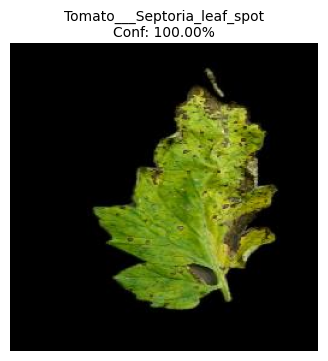

In [22]:
import matplotlib.pyplot as plt

def show_prediction(img_path, pred_info):
    img = Image.open(img_path).convert("RGB")
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis("off")
    title = f"{pred_info['top1_class']}\nConf: {pred_info['top1_confidence']*100:.2f}%"
    plt.title(title, fontsize=10, wrap=True)
    plt.show()

# after calling predict_image:
pred_info = predict_image(test_image_path, model, DEVICE)
show_prediction(test_image_path, pred_info)


In [23]:
import torch
import torch.nn.functional as F
import timm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
from pathlib import Path
import os

# ---------------------
# CONFIG
# ---------------------
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE     = 224

# If class_names not defined in this session, define it here EXACTLY in your training idx order:
class_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
]
NUM_CLASSES = len(class_names)

# same preprocessing as validation / test
preprocess = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def build_model(num_classes: int):
    model = timm.create_model(
        "efficientnet_b0",
        pretrained=False,
        num_classes=num_classes
    )
    return model

def load_trained_model(model_path: Path, device: str):
    model = build_model(NUM_CLASSES)
    ckpt = torch.load(model_path, map_location=device)

    # checkpoint might be raw state_dict or dict with "model_state_dict"
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt:
        state_dict = ckpt["model_state_dict"]
    else:
        state_dict = ckpt

    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    if missing or unexpected:
        print("⚠️  load_state_dict mismatch:")
        print("   missing   :", missing)
        print("   unexpected:", unexpected)

    model.eval().to(device)
    return model


# -------- Grad-CAM helper --------
class GradCAM:
    """
    Minimal Grad-CAM for timm EfficientNet-B0.
    We'll hook the last conv layer.
    """

    def __init__(self, model, target_layer_name: str):
        self.model = model
        self.model.eval()

        self.gradients = None
        self.activations = None

        # Get layer reference
        target_layer = dict([*model.named_modules()])[target_layer_name]

        # Hook forward to get activations
        def fwd_hook(module, inp, out):
            self.activations = out.detach()

        # Hook backward to get gradients
        def bwd_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_backward_hook(bwd_hook)

    def generate(self, input_tensor: torch.Tensor, class_idx: int, device: str):
        """
        input_tensor: [1,3,224,224] preprocessed tensor on device
        class_idx: int, target class index to visualize
        returns: heatmap (H,W) in [0,1]
        """
        self.model.zero_grad()

        logits = self.model(input_tensor)  # [1, num_classes]
        score = logits[:, class_idx]       # scalar for that class
        score.backward(retain_graph=True)

        # gradients: [1, C, H, W]
        # activations: [1, C, H, W]
        grads = self.gradients            # (1,C,h,w)
        acts  = self.activations          # (1,C,h,w)

        # global-average-pool the gradients: (C,)
        weights = grads.mean(dim=(2,3), keepdim=True)  # (1,C,1,1)

        # weighted sum of activations
        cam = (weights * acts).sum(dim=1, keepdim=True)  # (1,1,h,w)
        cam = F.relu(cam)  # only positive importance

        # normalize to [0,1]
        cam = cam[0,0]  # (h,w)
        cam -= cam.min()
        if cam.max() > 0:
            cam /= cam.max()

        # upscale CAM to input size (224x224)
        cam_up = F.interpolate(
            cam.unsqueeze(0).unsqueeze(0),
            size=(IMG_SIZE, IMG_SIZE),
            mode="bilinear",
            align_corners=False
        )[0,0]

        return cam_up.cpu().numpy()  # (224,224) float32 in [0,1]


def overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.4):
    """
    img_rgb: PIL Image (RGB)
    heatmap: (H,W) np.array in [0,1]
    alpha: overlay strength
    returns matplotlib figure
    """
    import matplotlib.cm as cm

    # to numpy
    img_np = np.array(img_rgb).astype(np.float32) / 255.0  # [H,W,3]

    # apply colormap to heatmap
    cmap = cm.get_cmap('jet')  # jet -> red/yellow for high response
    heatmap_color = cmap(heatmap)[...,:3]  # [H,W,3], drop alpha

    # overlay
    overlay = (1 - alpha) * img_np + alpha * heatmap_color
    overlay = np.clip(overlay, 0, 1)

    # show side by side
    fig, axs = plt.subplots(1, 3, figsize=(12,4))

    axs[0].imshow(img_rgb)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(heatmap, cmap='jet')
    axs[1].set_title("Grad-CAM Heatmap")
    axs[1].axis("off")

    axs[2].imshow(overlay)
    axs[2].set_title("Overlay")
    axs[2].axis("off")

    plt.tight_layout()
    return fig


@torch.inference_mode(False)  # we DO need gradients in Grad-CAM
def run_gradcam_on_image(img_path: str):
    # 1. load image
    pil_img = Image.open(img_path).convert("RGB")

    # 2. preprocess for model
    inp = preprocess(pil_img).unsqueeze(0).to(DEVICE)  # [1,3,224,224]

    # 3. forward to get prediction first (no grad)
    with torch.no_grad():
        logits = model(inp)
        probs = torch.softmax(logits, dim=1)[0]
        top1_prob, top1_idx = probs.max(dim=0)

    predicted_class_idx = top1_idx.item()
    predicted_class_name = class_names[predicted_class_idx]
    confidence = float(top1_prob.item()) * 100.0

    print(f"\n📸 Image: {img_path}")
    print(f"🔮 Predicted: {predicted_class_name} ({confidence:.2f}% confidence)")

    # 4. Grad-CAM (we need grad, so no torch.no_grad now)
    cam_generator = GradCAM(model, target_layer_name="conv_head")  
    # NOTE: for EfficientNet-B0 in timm, "conv_head" is the last conv before classifier
    # If this fails, we can try "blocks[-1].bn2" etc., but conv_head usually works.

    heatmap = cam_generator.generate(inp, predicted_class_idx, DEVICE)

    # 5. visualize overlay
    fig = overlay_heatmap_on_image(pil_img.resize((IMG_SIZE, IMG_SIZE)), heatmap, alpha=0.45)
    plt.show()

    return {
        "pred_class": predicted_class_name,
        "confidence": confidence,
        "heatmap": heatmap
    }


# ---- build and load model once ----
model = load_trained_model(MODEL_PATH, DEVICE)
print("✅ model loaded and ready for Grad-CAM")


/tmp/ipykernel_58588/423819935.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=device)


✅ model loaded and ready for Grad-CAM



📸 Image: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Tomato___Septoria_leaf_spot/Tomato___Septoria_leaf_spot_000158.jpg
🔮 Predicted: Tomato___Septoria_leaf_spot (100.00% confidence)


/tmp/ipykernel_58588/423819935.py:165: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('jet')  # jet -> red/yellow for high response


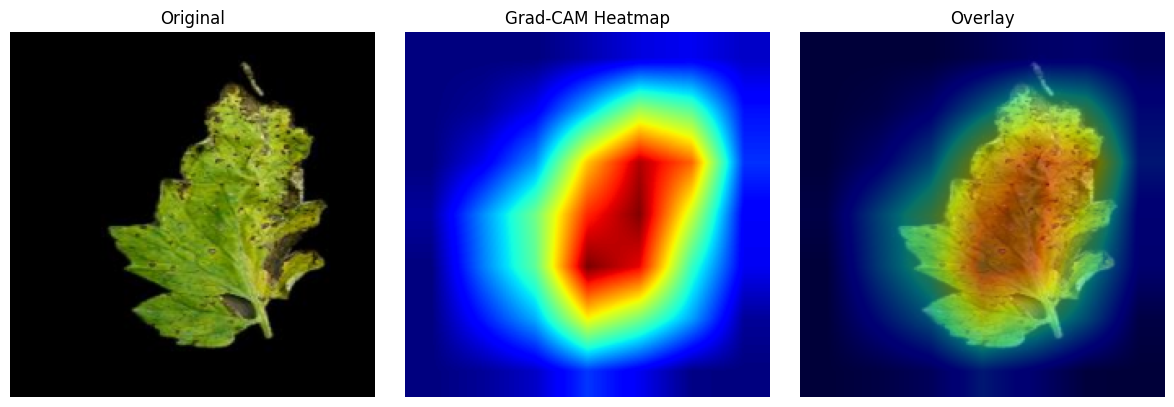

In [24]:
test_image_path = "/home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Tomato___Septoria_leaf_spot/Tomato___Septoria_leaf_spot_000158.jpg"
result = run_gradcam_on_image(test_image_path)


In [20]:
import os
import shutil
from pathlib import Path
import csv
from tqdm.auto import tqdm

# ============
# 1. Paths
# ============
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
SRC_ROOT     = PROJECT_ROOT / "data"          # original dataset
DST_ROOT     = PROJECT_ROOT / "data_renamed"  # new cleaned dataset

SPLITS = ["train", "val", "test"]  # we'll process all 3


# ============
# 2. Helper to zero-pad numbers
# ============
def make_new_name(class_name: str, idx: int, ext: str) -> str:
    """
    class_name: 'Tomato___Late_blight'
    idx:        1 -> 000001
    ext:        '.jpg'
    return:     'Tomato___Late_blight_000001.jpg'
    """
    return f"{class_name}_{idx:06d}{ext.lower()}"


# ============
# 3. Do the renaming (copy-based)
# ============
DST_ROOT.mkdir(parents=True, exist_ok=True)

for split in SPLITS:
    print(f"\n🔄 Processing split: {split}")
    split_src = SRC_ROOT / split
    split_dst = DST_ROOT / split
    split_dst.mkdir(parents=True, exist_ok=True)

    # We'll record a mapping file for this split
    mapping_rows = [("class_name","old_path","new_path")]

    # loop over every class folder in this split
    class_folders = sorted([p for p in split_src.iterdir() if p.is_dir()])

    for class_dir in tqdm(class_folders, desc=f"{split} classes"):
        class_name = class_dir.name  # e.g. "Tomato___Late_blight"
        dst_class_dir = split_dst / class_name
        dst_class_dir.mkdir(parents=True, exist_ok=True)

        # find all images in this class folder
        images = sorted([
            p for p in class_dir.iterdir()
            if p.is_file() and p.suffix.lower() in [".jpg", ".jpeg", ".png"]
        ])

        # rename sequentially within this class
        for idx, img_path in enumerate(images, start=1):
            new_filename = make_new_name(class_name, idx, img_path.suffix)
            dst_path = dst_class_dir / new_filename

            # copy image
            shutil.copy2(img_path, dst_path)

            # log mapping
            mapping_rows.append((
                class_name,
                str(img_path),
                str(dst_path)
            ))

    # write mapping CSV for this split
    mapping_csv_path = DST_ROOT / f"{split}_rename_map.csv"
    with open(mapping_csv_path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerows(mapping_rows)

    print(f"✅ Finished {split}:")
    print(f"   ↳ Saved renamed images under: {split_dst}")
    print(f"   ↳ Mapping CSV: {mapping_csv_path}")

print("\n🎉 ALL DONE!")
print(f"Your clean dataset is now in: {DST_ROOT}")
print("You can now train / export / segment using data_renamed/ to keep things stable.")



🔄 Processing split: train


train classes: 100%|██████████| 23/23 [00:06<00:00,  3.66it/s]


✅ Finished train:
   ↳ Saved renamed images under: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/train
   ↳ Mapping CSV: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/train_rename_map.csv

🔄 Processing split: val


val classes: 100%|██████████| 23/23 [00:01<00:00, 17.27it/s]


✅ Finished val:
   ↳ Saved renamed images under: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/val
   ↳ Mapping CSV: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/val_rename_map.csv

🔄 Processing split: test


test classes: 100%|██████████| 23/23 [00:00<00:00, 31.76it/s]

✅ Finished test:
   ↳ Saved renamed images under: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test
   ↳ Mapping CSV: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test_rename_map.csv

🎉 ALL DONE!
Your clean dataset is now in: /home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed
You can now train / export / segment using data_renamed/ to keep things stable.


/tmp/ipykernel_58588/1335634339.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location=DEVICE)


Loaded model weights.
  (missing keys) ['backbone.conv_stem.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.blocks.0.0.conv_dw.weight', 'backbone.blocks.0.0.bn1.weight', 'backbone.blocks.0.0.bn1.bias', 'backbone.blocks.0.0.bn1.running_mean', 'backbone.blocks.0.0.bn1.running_var', 'backbone.blocks.0.0.se.conv_reduce.weight', 'backbone.blocks.0.0.se.conv_reduce.bias', 'backbone.blocks.0.0.se.conv_expand.weight', 'backbone.blocks.0.0.se.conv_expand.bias', 'backbone.blocks.0.0.conv_pw.weight', 'backbone.blocks.0.0.bn2.weight', 'backbone.blocks.0.0.bn2.bias', 'backbone.blocks.0.0.bn2.running_mean', 'backbone.blocks.0.0.bn2.running_var', 'backbone.blocks.1.0.conv_pw.weight', 'backbone.blocks.1.0.bn1.weight', 'backbone.blocks.1.0.bn1.bias', 'backbone.blocks.1.0.bn1.running_mean', 'backbone.blocks.1.0.bn1.running_var', 'backbone.blocks.1.0.conv_dw.weight', 'backbone.blocks.1.0.bn2.weight', 'backbone.blocks.1.0.bn2.bias', '

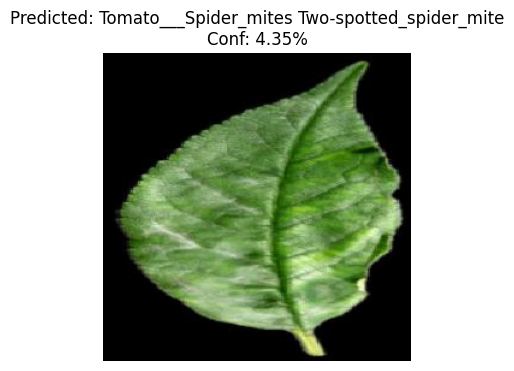


✅ Final Result:
{'top1_class': 'Tomato___Spider_mites Two-spotted_spider_mite', 'top1_conf': 0.04348229616880417, 'topk_classes': ['Tomato___Spider_mites Two-spotted_spider_mite', 'Apple___Black_rot', 'Apple___Cedar_apple_rust'], 'topk_scores': [0.04348229616880417, 0.04348155856132507, 0.043480996042490005]}


In [27]:
import os
import torch
import timm
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pathlib import Path

# -------------------------------------------------
# CONFIG
# -------------------------------------------------

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Paths
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"   # <- your trained checkpoint
CLASS_NAMES_PATH = PROJECT_ROOT / "models" / "class_names.json"  # we'll fall back if missing

# Same classes we used in training (order matters!)
CLASS_NAMES_FALLBACK = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite"
]

# -------------------------------------------------
# MODEL DEF (must match training architecture)
# -------------------------------------------------

class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=23):
        super().__init__()
        # efficientnet_b0 from timm
        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=False,
            num_classes=num_classes  # linear head with out_features=23
        )

    def forward(self, x):
        return self.backbone(x)

# -------------------------------------------------
# LOAD MODEL + WEIGHTS
# -------------------------------------------------

def load_trained_model(model_path):
    # 1. recreate model shell
    model = PlantDiseaseClassifier(num_classes=len(CLASS_NAMES_FALLBACK)).to(DEVICE)

    # 2. load checkpoint (we saved full checkpoint with model_state_dict)
    ckpt = torch.load(model_path, map_location=DEVICE)
    if "model_state_dict" in ckpt:
        state = ckpt["model_state_dict"]
    else:
        # in case you directly saved model.state_dict()
        state = ckpt

    # 3. load weights
    missing, unexpected = model.load_state_dict(state, strict=False)
    print("Loaded model weights.")
    if missing:
        print("  (missing keys)", missing)
    if unexpected:
        print("  (unexpected keys)", unexpected)

    model.eval()
    return model, ckpt

model, ckpt = load_trained_model(MODEL_PATH)

# -------------------------------------------------
# CLASS NAMES
# -------------------------------------------------

import json
if CLASS_NAMES_PATH.exists():
    try:
        class_names = json.loads(CLASS_NAMES_PATH.read_text())
        print(f"Loaded {len(class_names)} class names from file.")
    except:
        print("⚠️ Could not parse class_names.json, using fallback.")
        class_names = CLASS_NAMES_FALLBACK
elif "class_names" in ckpt:
    class_names = ckpt["class_names"]
    print(f"Loaded {len(class_names)} class names from checkpoint.")
else:
    print("⚠️ Using fallback class names.")
    class_names = CLASS_NAMES_FALLBACK

# safety check
assert len(class_names) == model.backbone.classifier.out_features, \
    "Mismatch between class_names and model head output size."

# -------------------------------------------------
# IMAGE PREPROCESS (must match training transforms for val/test)
# -------------------------------------------------

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # same CONFIG['IMG_SIZE']
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

def load_image_for_model(img_path):
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = val_transform(img_pil)  # [3,224,224]
    img_batch = img_tensor.unsqueeze(0).to(DEVICE)  # [1,3,224,224]
    return img_pil, img_batch

# -------------------------------------------------
# PREDICT
# -------------------------------------------------

@torch.no_grad()
def predict_image(img_path, topk=3):
    img_pil, img_batch = load_image_for_model(img_path)

    logits = model(img_batch)           # [1, num_classes]
    probs  = F.softmax(logits, dim=1)   # convert to probabilities
    probs_np = probs.squeeze(0).cpu().numpy()

    # top-k
    top_idx = probs.squeeze(0).topk(topk).indices.cpu().tolist()
    top_scores = probs.squeeze(0).topk(topk).values.cpu().tolist()

    print("\n📸 Image:", img_path)
    print("🔎 Top predictions:")
    for rank, (idx, sc) in enumerate(zip(top_idx, top_scores), start=1):
        print(f"   {rank}. {class_names[idx]}  ({sc*100:.2f}%)")

    # visualize
    plt.figure(figsize=(4,4))
    plt.imshow(img_pil)
    plt.axis("off")
    plt.title(f"Predicted: {class_names[top_idx[0]]}\nConf: {top_scores[0]*100:.2f}%")
    plt.show()

    return {
        "top1_class": class_names[top_idx[0]],
        "top1_conf": top_scores[0],
        "topk_classes": [class_names[i] for i in top_idx],
        "topk_scores": top_scores
    }

# -------------------------------------------------
# 🔥 RUN DEMO HERE
# -------------------------------------------------

# CHANGE THIS to any image path you want to test:
# - can be from train/val/test folders
# - or any new leaf image you downloaded
IMG_PATH = "/home/muhammad-noman/projects/plant_disease-gpu-env/data_renamed/test/Cherry_(including_sour)___Powdery_mildew/Cherry_(including_sour)___Powdery_mildew_000070.jpg"

result = predict_image(IMG_PATH, topk=3)
print("\n✅ Final Result:")
print(result)
# 

In [29]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import timm

# =========================================
# 0. CONFIG (edit these paths if needed)
# =========================================
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"   # your trained classifier checkpoint
CLASS_NAMES  = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
]
NUM_CLASSES = len(CLASS_NAMES)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# put the path of ANY test image you want to analyze:
IMAGE_PATH = PROJECT_ROOT / "data" / "test" / "Tomato___Late_blight" / os.listdir(PROJECT_ROOT / "data" / "test" / "Tomato___Late_blight")[0]

# where to save Grad-CAM outputs
OUT_DIR = PROJECT_ROOT / "outputs" / "gradcam"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# =========================================
# 1. RECREATE YOUR TRAINED MODEL
#    (must match what you trained: efficientnet_b0 + your linear head)
# =========================================
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # your backbone
        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=False,
            num_classes=0  # no classifier head from timm
        )
        in_features = self.backbone.num_features  # embedding dim

        # your classifier head from training
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        feats = self.backbone(x)        # [B, in_features]
        logits = self.classifier(feats) # [B, num_classes]
        return logits

model = PlantDiseaseClassifier(num_classes=NUM_CLASSES).to(DEVICE)
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()
print("✅ Loaded trained classifier and moved to eval().")

# =========================================
# 2. PREPROCESS THE INPUT IMAGE
#    (must match training transforms: resize 224, normalize ImageNet stats)
# =========================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

raw_img_pil = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = preprocess(raw_img_pil).unsqueeze(0).to(DEVICE)  # [1,3,224,224]

# =========================================
# 3. GRAD-CAM HOOKS
#    We grab activations + gradients from the LAST conv layer of the backbone.
#    For EfficientNet-B0 in timm, last feature layer is usually model.backbone.conv_head or model.backbone.blocks[-1]
#    We'll use the last convolutional feature map before global pooling.
# =========================================

# We will try to tap into the last feature map the backbone returns internally.
# timm efficientnet_b0 backbone.forward() already returns pooled features,
# so we need a small trick: forward_features() gives spatial feature maps.
assert hasattr(model.backbone, "forward_features"), "Unexpected backbone structure."

target_activations = {}
target_gradients   = {}

def save_activation(module, x, y):
    # y is output of the layer
    target_activations["value"] = y.detach()

def save_gradient(module, grad_input, grad_output):
    # grad_output is tuple; we want grad of layer output
    target_gradients["value"] = grad_output[0].detach()

# We'll hook the last conv layer in EfficientNet
last_conv = model.backbone.conv_head
last_conv.register_forward_hook(save_activation)
last_conv.register_backward_hook(save_gradient)

# =========================================
# 4. FORWARD PASS + BACKWARD ON TARGET CLASS
# =========================================
with torch.no_grad():
    logits = model(input_tensor)  # [1, num_classes]
probs = F.softmax(logits, dim=1)[0]  # [num_classes]
pred_idx = torch.argmax(probs).item()
pred_class_name = CLASS_NAMES[pred_idx]
pred_conf = probs[pred_idx].item()

print(f"🔍 Predicted class: {pred_class_name} ({pred_conf*100:.2f}%)")

# now we enable grad for CAM
model.zero_grad()
logits[0, pred_idx].backward(retain_graph=True)

# get activations and gradients
acts = target_activations["value"]        # shape [1, C, H, W]
grads = target_gradients["value"]         # shape [1, C, H, W]
weights = grads.mean(dim=(2,3), keepdim=True)  # GAP over H,W → [1, C, 1, 1]

# weighted sum of channels
cam = (acts * weights).sum(dim=1, keepdim=False)  # [1, H, W] -> [H,W]
cam = cam.squeeze(0)  # [H,W]

# ReLU (keep only positive importance)
cam = torch.relu(cam)

# normalize CAM to [0,1]
cam -= cam.min()
if cam.max() > 0:
    cam /= cam.max()

cam_np = cam.detach().cpu().numpy()  # [H,W]

# Resize CAM to original image size for visualization
orig_w, orig_h = raw_img_pil.size
cam_resized = cv2.resize(cam_np, (orig_w, orig_h))

# =========================================
# 5. VISUALIZE AND SAVE HEATMAP OVERLAY
# =========================================
# convert original image to np
img_np = np.array(raw_img_pil)  # H,W,3 in RGB

# create heatmap color
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * cam_resized),
    cv2.COLORMAP_JET
)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# overlay (alpha blend)
alpha = 0.4
overlay = (alpha * heatmap_color + (1 - alpha) * img_np).astype(np.uint8)

# show inline
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cam_resized, cmap='jet')
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Overlay: {pred_class_name}")
plt.imshow(overlay)
plt.axis("off")
plt.tight_layout()
plt.show()

# save results
base_name = IMAGE_PATH.stem
out_cam_path      = OUT_DIR / f"{base_name}_cam.png"
out_overlay_path  = OUT_DIR / f"{base_name}_overlay.png"
out_raw_heat_path = OUT_DIR / f"{base_name}_heat.npy"  # we keep raw CAM so we can later threshold it

plt.imsave(out_cam_path, cam_resized, cmap='jet')
Image.fromarray(overlay).save(out_overlay_path)
np.save(out_raw_heat_path, cam_resized)

print(f"✅ Saved:")
print(f"   Heatmap (viewable) : {out_cam_path}")
print(f"   Overlay (pretty)   : {out_overlay_path}")
print(f"   Raw heat (for mask): {out_raw_heat_path}")
print(f"\nPredicted: {pred_class_name} ({pred_conf*100:.2f}%)")


/tmp/ipykernel_58588/1104396842.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


✅ Loaded trained classifier and moved to eval().
🔍 Predicted class: Tomato___Late_blight (4.41%)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

/tmp/ipykernel_58588/2875263009.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


✅ Loaded model & enabled gradients for CAM.
🔍 Prediction: Tomato___Late_blight (4.41%)


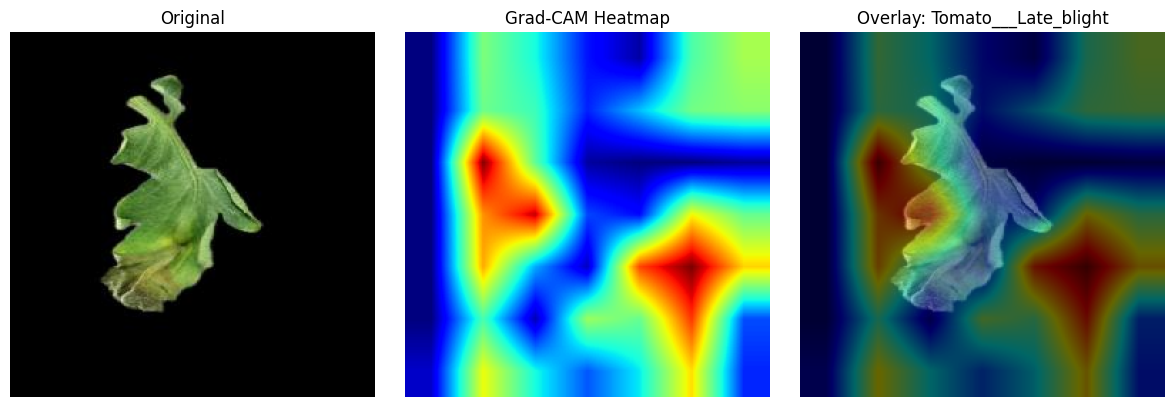

✅ Saved:
   Heatmap image : /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/gradcam/f08ebd91-a148-4494-a45c-55ebc1bf1f60___GHLB2 Leaf 8942_final_masked_cam.png
   Overlay image : /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/gradcam/f08ebd91-a148-4494-a45c-55ebc1bf1f60___GHLB2 Leaf 8942_final_masked_overlay.png
   Raw CAM .npy  : /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/gradcam/f08ebd91-a148-4494-a45c-55ebc1bf1f60___GHLB2 Leaf 8942_final_masked_heat.npy

Predicted: Tomato___Late_blight (4.41%)


In [30]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import timm

# =========================================
# 0. CONFIG
# =========================================
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"

CLASS_NAMES  = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
]
NUM_CLASSES = len(CLASS_NAMES)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# pick any test image, you can change this to whatever you want
IMAGE_PATH = PROJECT_ROOT / "data" / "test" / "Tomato___Late_blight" / os.listdir(PROJECT_ROOT / "data" / "test" / "Tomato___Late_blight")[0]

OUT_DIR = PROJECT_ROOT / "outputs" / "gradcam"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# =========================================
# 1. MODEL DEFINITION (must match training)
# =========================================
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.backbone = timm.create_model(
            'efficientnet_b0',
            pretrained=False,
            num_classes=0  # no built-in head
        )
        in_features = self.backbone.num_features
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        feats = self.backbone(x)        # [B, C]
        logits = self.classifier(feats) # [B, num_classes]
        return logits

model = PlantDiseaseClassifier(num_classes=NUM_CLASSES).to(DEVICE)

ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval()

# make sure all params can require grad for CAM (even if we froze backbone during training)
for p in model.parameters():
    p.requires_grad_(True)

print("✅ Loaded model & enabled gradients for CAM.")

# =========================================
# 2. PREPROCESS IMAGE
# =========================================
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

raw_img_pil = Image.open(IMAGE_PATH).convert("RGB")
input_tensor = preprocess(raw_img_pil).unsqueeze(0).to(DEVICE)  # shape [1,3,224,224]

# =========================================
# 3. HOOKS FOR GRAD-CAM
# we'll hook last conv layer to get activations + gradients
# =========================================
target_activations = {}
target_gradients   = {}

def save_activation(module, x, y):
    target_activations["value"] = y.detach()

def save_gradient(module, grad_input, grad_output):
    target_gradients["value"] = grad_output[0].detach()

# EfficientNet-B0 from timm has conv_head as last conv before pooling
last_conv = model.backbone.conv_head
last_conv.register_forward_hook(save_activation)
last_conv.register_backward_hook(save_gradient)

# =========================================
# 4. FORWARD PASS #1 (no grad) just to get prediction
# =========================================
with torch.no_grad():
    logits_nograd = model(input_tensor)
    probs = F.softmax(logits_nograd, dim=1)[0]
    pred_idx = torch.argmax(probs).item()
    pred_class_name = CLASS_NAMES[pred_idx]
    pred_conf = probs[pred_idx].item()

print(f"🔍 Prediction: {pred_class_name} ({pred_conf*100:.2f}%)")

# =========================================
# 5. FORWARD PASS #2 (WITH grad) for CAM
#    we do it again WITHOUT torch.no_grad()
# =========================================
model.zero_grad()

logits = model(input_tensor)  # now this tensor tracks grad
score_for_target = logits[0, pred_idx]

# backward from the target class
score_for_target.backward(retain_graph=True)

# grab saved activations & gradients from hook
acts  = target_activations["value"]     # [1, C, H, W]
grads = target_gradients["value"]       # [1, C, H, W]

# global-average-pool the gradients to get weights per channel
weights = grads.mean(dim=(2,3), keepdim=True)  # [1, C, 1, 1]

# weighted sum of activations
cam = (acts * weights).sum(dim=1, keepdim=False)  # [1, H, W] -> [H,W]
cam = cam.squeeze(0)

# keep positive only
cam = torch.relu(cam)

# normalize to [0,1]
cam -= cam.min()
if cam.max() > 0:
    cam /= cam.max()

cam_np = cam.detach().cpu().numpy()  # [H,W]

# =========================================
# 6. UPSAMPLE CAM TO ORIGINAL IMAGE SIZE AND VISUALIZE
# =========================================
orig_w, orig_h = raw_img_pil.size
cam_resized = cv2.resize(cam_np, (orig_w, orig_h))

img_np = np.array(raw_img_pil)  # RGB

# colorize heatmap
heatmap_color = cv2.applyColorMap(
    np.uint8(255 * cam_resized),
    cv2.COLORMAP_JET
)
heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

# overlay
alpha = 0.4
overlay = (alpha * heatmap_color + (1 - alpha) * img_np).astype(np.uint8)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cam_resized, cmap='jet')
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Overlay: {pred_class_name}")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()

# =========================================
# 7. SAVE RESULTS
# we'll save:
#  - pretty overlay (for report)
#  - heatmap png
#  - raw heatmap npy (for future pseudo-masks)
# =========================================
base_name = IMAGE_PATH.stem
out_cam_path      = OUT_DIR / f"{base_name}_cam.png"
out_overlay_path  = OUT_DIR / f"{base_name}_overlay.png"
out_raw_heat_path = OUT_DIR / f"{base_name}_heat.npy"

plt.imsave(out_cam_path, cam_resized, cmap='jet')
Image.fromarray(overlay).save(out_overlay_path)
np.save(out_raw_heat_path, cam_resized)

print("✅ Saved:")
print(f"   Heatmap image : {out_cam_path}")
print(f"   Overlay image : {out_overlay_path}")
print(f"   Raw CAM .npy  : {out_raw_heat_path}")
print(f"\nPredicted: {pred_class_name} ({pred_conf*100:.2f}%)")


Classes (23): ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy'] ...


/tmp/ipykernel_58588/349730959.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


Loaded model. Missing keys: []
Unexpected keys: []

📝 We'll generate pseudo masks for:
  Apple___Apple_scab: 50 images
  Apple___Black_rot: 50 images
  Apple___Cedar_apple_rust: 50 images
  Apple___healthy: 50 images
  Blueberry___healthy: 50 images
  Cherry_(including_sour)___Powdery_mildew: 50 images
  Cherry_(including_sour)___healthy: 50 images
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 50 images
  Corn_(maize)___Common_rust_: 50 images
  Corn_(maize)___Northern_Leaf_Blight: 50 images
  Corn_(maize)___healthy: 50 images
  Grape___Black_rot: 50 images
  Grape___Esca_(Black_Measles): 50 images
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 50 images
  Grape___healthy: 50 images
  Pepper,_bell___healthy: 50 images
  Potato___Early_blight: 50 images
  Potato___Late_blight: 50 images
  Potato___healthy: 50 images
  Tomato___Late_blight: 50 images
  Tomato___Leaf_Mold: 50 images
  Tomato___Septoria_leaf_spot: 50 images
  Tomato___Spider_mites Two-spotted_spider_mite: 50 images


Apple___Apple_scab:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_58588/349730959.py:186: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(lesion_mask.astype(np.uint8), mode="L")



✅ Done. Saved 1150 (image,mask) pairs to /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/pseudo_masks


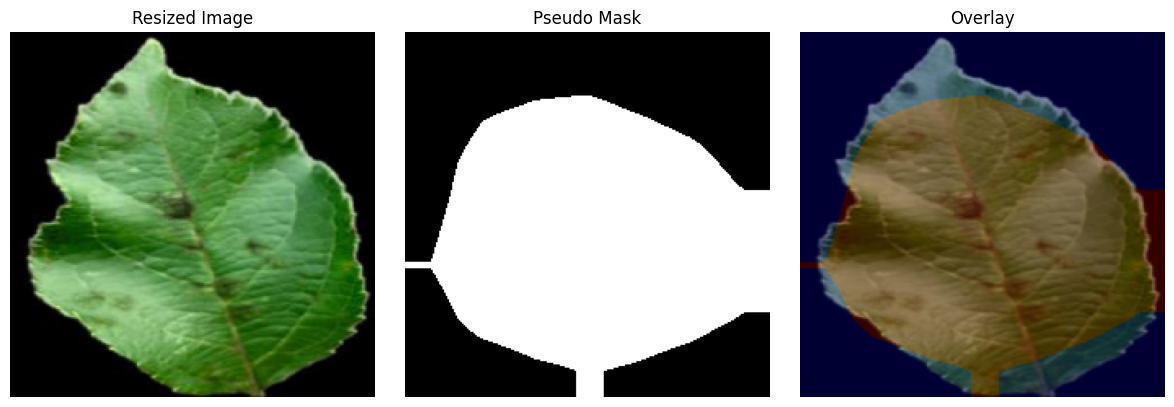

In [32]:
import os, torch, json, numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ====== CONFIG ======
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
DATA_ROOT    = PROJECT_ROOT / "data" / "train"   # we'll sample from train for CAM masks
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"
OUT_ROOT     = PROJECT_ROOT / "outputs" / "pseudo_masks"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 224
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_LIMIT_PER_CLASS = 50   # how many images per class to generate masks for (tune this)

# ====== 1. Load class names from the actual train directory ======
class_names = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names[:5], "...")

class_to_idx = {cls:i for i,cls in enumerate(class_names)}
idx_to_class = {i:cls for cls,i in class_to_idx.items()}

# ====== 2. Rebuild the SAME model arch that you trained ======
import timm
import torch.nn as nn

def build_model(num_classes):
    m = timm.create_model('efficientnet_b0',
                          pretrained=False,
                          num_classes=num_classes)
    return m

model = build_model(num_classes).to(DEVICE)

# load checkpoint (strict=False is fine if there are extra keys)
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
missing, unexpected = model.load_state_dict(ckpt['model_state_dict'], strict=False)
print("Loaded model. Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()  # VERY IMPORTANT for Grad-CAM logic below


# ====== 3. Preprocess transform (same as validation/test transforms) ======
import torchvision.transforms as T
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])


# ====== 4. Grad-CAM helper ======
# We'll hook the last conv block of EfficientNet-B0
TARGET_LAYER_NAME = "conv_head"  # efficientnet_b0 final conv before pooling

def get_target_layer(model):
    # timm efficientnet_b0 typically has model.conv_head as last conv
    return model.conv_head

def generate_gradcam(rgb_tensor, model):
    """
    rgb_tensor: (1, 3, H, W) normalized input on DEVICE
    returns heatmap: (H, W) numpy in [0,1]
    """
    layer = get_target_layer(model)

    activations = {}
    gradients   = {}

    def fwd_hook(module, inp, out):
        activations["value"] = out

    def bwd_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    # register hooks
    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_full_backward_hook(bwd_hook)

    rgb_tensor.requires_grad_(True)

    # forward
    logits = model(rgb_tensor)
    pred_idx = logits.argmax(dim=1)

    # backward wrt predicted class
    model.zero_grad()
    logits[0, pred_idx].backward(retain_graph=True)

    # remove hooks
    h1.remove()
    h2.remove()

    A = activations["value"]      # [1, C, Hc, Wc]
    dA = gradients["value"]       # [1, C, Hc, Wc]

    # global average pool the gradients over spatial dims
    weights = dA.mean(dim=(2,3), keepdim=True)  # [1,C,1,1]

    # weighted sum of activations
    cam = (weights * A).sum(dim=1, keepdim=True)  # [1,1,Hc,Wc]
    cam = F.relu(cam)

    # upsample to input size
    cam = F.interpolate(cam, size=rgb_tensor.shape[2:], mode='bilinear', align_corners=False)

    # normalize to [0,1]
    cam = cam[0,0].detach().cpu().numpy()
    cam -= cam.min() + 1e-8
    cam /= cam.max() + 1e-8
    return cam, int(pred_idx.item())


# ====== 5. Utility: threshold CAM into a binary mask ======
def cam_to_mask(cam_map, thr=0.4):
    """
    cam_map: (H,W) in [0,1]
    thr: float threshold (0.4 means keep top ~60% energy)
    returns uint8 mask (0 or 255) same HxW
    """
    mask = (cam_map >= thr).astype(np.uint8) * 255
    return mask


# ====== 6. Iterate through dataset images and save pseudo masks ======
def collect_images_per_class(root_dir, limit_per_class=50):
    """
    returns dict[class_name] = [list of file paths]
    """
    out = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        imgs = []
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                imgs.append(os.path.join(cls_dir, fname))
        imgs = sorted(imgs)[:limit_per_class]
        out[cls] = imgs
    return out

per_class_files = collect_images_per_class(DATA_ROOT, limit_per_class=BATCH_LIMIT_PER_CLASS)

print("\n📝 We'll generate pseudo masks for:")
for cls, files in per_class_files.items():
    print(f"  {cls}: {len(files)} images")
print()

total_saved = 0

for cls_name, file_list in per_class_files.items():
    cls_out_dir = OUT_ROOT / cls_name
    cls_out_dir.mkdir(parents=True, exist_ok=True)

    for idx, img_path in enumerate(tqdm(file_list, desc=f"{cls_name}", leave=False)):
        # load PIL
        pil_img = Image.open(img_path).convert("RGB")

        # keep a resized copy (224x224 RGB) for training segmentation later
        pil_resized = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

        # preprocess to tensor
        inp_t = val_transform(pil_img).unsqueeze(0).to(DEVICE)

        # get cam + predicted class
        cam_map, predicted_idx = generate_gradcam(inp_t, model)

        # make binary lesion mask from cam
        lesion_mask = cam_to_mask(cam_map, thr=0.4)  # tune thr

        # save both image+mask with a shared stem
        stem = f"{cls_name}_{idx:05d}"
        out_img_path  = cls_out_dir / f"{stem}_img.png"
        out_mask_path = cls_out_dir / f"{stem}_mask.png"

        pil_resized.save(out_img_path)

        # mask -> PIL grayscale (0 or 255)
        mask_pil = Image.fromarray(lesion_mask.astype(np.uint8), mode="L")
        mask_pil.save(out_mask_path)

        total_saved += 1

print(f"\n✅ Done. Saved {total_saved} (image,mask) pairs to {OUT_ROOT}")

# quick sanity check visualization for one example
def quick_viz(sample_img_path, sample_mask_path):
    rgb = Image.open(sample_img_path).convert("RGB")
    msk = Image.open(sample_mask_path).convert("L")

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(rgb)
    ax[0].set_title("Resized Image")
    ax[0].axis("off")

    ax[1].imshow(msk, cmap="gray")
    ax[1].set_title("Pseudo Mask")
    ax[1].axis("off")

    ax[2].imshow(rgb)
    ax[2].imshow(msk, cmap="jet", alpha=0.4)
    ax[2].set_title("Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

# pick one random saved pair to preview
for cls_name in per_class_files:
    cls_dir = OUT_ROOT / cls_name
    candidates = sorted([p for p in cls_dir.glob("*_img.png")])
    if not candidates:
        continue
    first_img = candidates[0]
    first_mask = str(first_img).replace("_img.png", "_mask.png")
    quick_viz(first_img, first_mask)
    break


/tmp/ipykernel_58588/39403522.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=DEVICE)


We'll generate STRICT lesion masks into: /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/pseudo_lesion_masks_strict


Apple___Apple_scab:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_58588/39403522.py:135: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(lesion_mask.astype(np.uint8), mode="L")



✅ Done. Saved 1150 (image,STRICT lesion mask) pairs to /home/muhammad-noman/projects/plant_disease-gpu-env/outputs/pseudo_lesion_masks_strict


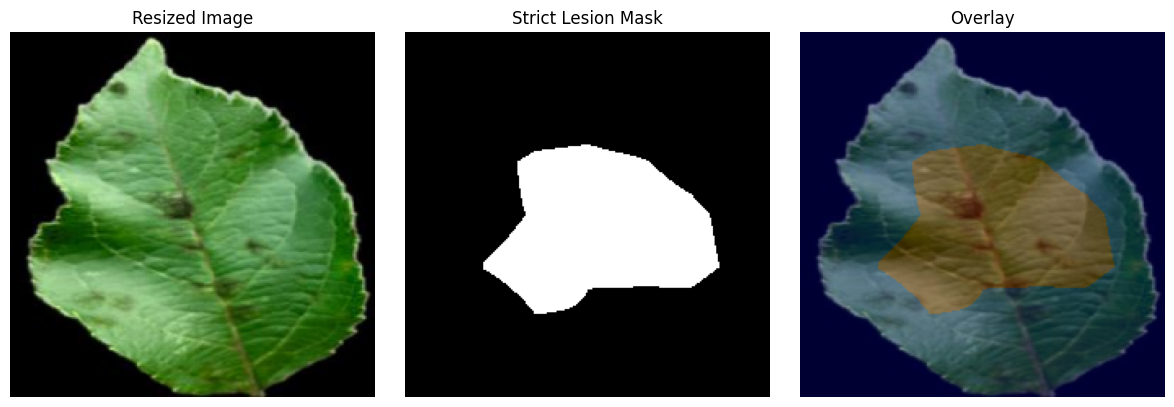

In [36]:
import os, torch, json, numpy as np
from pathlib import Path
from PIL import Image
from tqdm.auto import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
import timm
import torch.nn as nn

# ========= config =========
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
DATA_ROOT    = PROJECT_ROOT / "data" / "train"   # we'll sample train again
MODEL_PATH   = PROJECT_ROOT / "models" / "best_model.pth"

OUT_ROOT     = PROJECT_ROOT / "outputs" / "pseudo_lesion_masks_strict"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 224
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_LIMIT_PER_CLASS = 50  # keep same limit for now

# ========= rebuild model + load weights (same as before) =========
class_names = sorted([d.name for d in DATA_ROOT.iterdir() if d.is_dir()])
num_classes = len(class_names)

def build_model(num_classes):
    m = timm.create_model('efficientnet_b0',
                          pretrained=False,
                          num_classes=num_classes)
    return m

model = build_model(num_classes).to(DEVICE)
ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'], strict=False)
model.eval()

val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

TARGET_LAYER_NAME = "conv_head"
def get_target_layer(model):
    return model.conv_head

def generate_gradcam(rgb_tensor, model):
    layer = get_target_layer(model)
    activations = {}
    gradients   = {}

    def fwd_hook(module, inp, out):
        activations["value"] = out
    def bwd_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0]

    h1 = layer.register_forward_hook(fwd_hook)
    h2 = layer.register_full_backward_hook(bwd_hook)

    rgb_tensor.requires_grad_(True)
    logits = model(rgb_tensor)
    pred_idx = logits.argmax(dim=1)

    model.zero_grad()
    logits[0, pred_idx].backward(retain_graph=True)

    h1.remove()
    h2.remove()

    A   = activations["value"]         # [1,C,Hc,Wc]
    dA  = gradients["value"]           # [1,C,Hc,Wc]
    wts = dA.mean(dim=(2,3), keepdim=True)
    cam = (wts * A).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=rgb_tensor.shape[2:], mode='bilinear', align_corners=False)
    cam = cam[0,0].detach().cpu().numpy()

    cam -= cam.min() + 1e-8
    cam /= cam.max() + 1e-8
    return cam, int(pred_idx.item())

def cam_to_top_percent_mask(cam_map, keep_top=0.20):
    """
    cam_map: [H,W] in [0,1]
    keep_top: fraction of hottest pixels to keep as 1
    returns uint8 mask (0 or 255)
    """
    flat = cam_map.flatten()
    # find threshold at the (1-keep_top) quantile
    thr_val = np.quantile(flat, 1.0 - keep_top)
    lesion_mask = (cam_map >= thr_val).astype(np.uint8) * 255
    return lesion_mask

def collect_images_per_class(root_dir, limit_per_class=50):
    result = {}
    for cls in sorted(os.listdir(root_dir)):
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        imgs = []
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                imgs.append(os.path.join(cls_dir, fname))
        imgs = sorted(imgs)[:limit_per_class]
        result[cls] = imgs
    return result

per_class_files = collect_images_per_class(DATA_ROOT, limit_per_class=BATCH_LIMIT_PER_CLASS)
print("We'll generate STRICT lesion masks into:", OUT_ROOT)
total_saved = 0

for cls_name, file_list in per_class_files.items():
    cls_out_dir = OUT_ROOT / cls_name
    cls_out_dir.mkdir(parents=True, exist_ok=True)

    for idx, img_path in enumerate(tqdm(file_list, desc=f"{cls_name}", leave=False)):
        pil_img = Image.open(img_path).convert("RGB")
        pil_resized = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)

        inp_t = val_transform(pil_img).unsqueeze(0).to(DEVICE)

        cam_map, pred_idx = generate_gradcam(inp_t, model)

        # 🔥 use top 20% hottest pixels only
        lesion_mask = cam_to_top_percent_mask(cam_map, keep_top=0.20)

        stem = f"{cls_name}_{idx:05d}"
        out_img_path  = cls_out_dir / f"{stem}_img.png"
        out_mask_path = cls_out_dir / f"{stem}_mask.png"

        pil_resized.save(out_img_path)

        mask_pil = Image.fromarray(lesion_mask.astype(np.uint8), mode="L")
        mask_pil.save(out_mask_path)

        total_saved += 1

print(f"\n✅ Done. Saved {total_saved} (image,STRICT lesion mask) pairs to {OUT_ROOT}")

# sanity check visualization
def quick_viz(img_path, mask_path):
    rgb = Image.open(img_path).convert("RGB")
    msk = Image.open(mask_path).convert("L")

    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(rgb); ax[0].set_title("Resized Image"); ax[0].axis("off")
    ax[1].imshow(msk, cmap="gray"); ax[1].set_title("Strict Lesion Mask"); ax[1].axis("off")
    ax[2].imshow(rgb); ax[2].imshow(msk, cmap="jet", alpha=0.4)
    ax[2].set_title("Overlay"); ax[2].axis("off")
    plt.tight_layout()
    plt.show()

# preview 1 example
for cls_name in per_class_files:
    cls_dir = OUT_ROOT / cls_name
    candidates = sorted([p for p in cls_dir.glob("*_img.png")])
    if not candidates:
        continue
    first_img = candidates[0]
    first_mask = str(first_img).replace("_img.png", "_mask.png")
    quick_viz(first_img, first_mask)
    break


In [37]:
import os
from pathlib import Path
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T

# ============ CONFIG ============
PROJECT_ROOT = Path("/home/muhammad-noman/projects/plant_disease-gpu-env")
PSEUDO_ROOT  = PROJECT_ROOT / "outputs" / "pseudo_lesion_masks_strict"
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"
IMG_SIZE     = 224
BATCH_SIZE   = 16   # if GPU OOM, drop to 8

# We'll fix randomness for reproducibility
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# --- transforms ---
# note: for mask we CANNOT use color jitter etc. Only spatial transforms.
class SegAugment:
    def __init__(self, img_size=224):
        self.img_tf = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.2),
            T.RandomRotation(degrees=20),
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        ])
        self.to_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
        ])
        self.mask_tf = None  # we apply same spatial ops manually
        self.resize = T.Resize((img_size, img_size))

    def __call__(self, img, mask):
        # img, mask are PIL
        # 1) resize both
        img  = self.resize(img)
        mask = self.resize(mask)

        # 2) apply SAME random spatial transforms
        # We'll pick random booleans then apply manually
        if random.random() < 0.5:
            img  = T.functional.hflip(img)
            mask = T.functional.hflip(mask)
        if random.random() < 0.2:
            img  = T.functional.vflip(img)
            mask = T.functional.vflip(mask)
        # random rotation
        angle = random.uniform(-20,20)
        img  = T.functional.rotate(img, angle)
        mask = T.functional.rotate(mask, angle, fill=0)

        # 3) color jitter ONLY to image
        img = self.img_tf.transforms[3](img)  # ColorJitter only

        # 4) tensor + normalize
        img_t = self.to_tensor(img)

        # mask -> tensor {0,1}, shape [1,H,W]
        mask = np.array(mask.convert("L"))
        mask_bin = (mask > 127).astype(np.float32)
        mask_t = torch.from_numpy(mask_bin).unsqueeze(0)  # [1,H,W]

        return img_t, mask_t

class SegNoAugment:
    def __init__(self, img_size=224):
        self.resize = T.Resize((img_size, img_size))
        self.to_tensor = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
        ])
    def __call__(self, img, mask):
        img  = self.resize(img)
        mask = self.resize(mask)

        img_t = self.to_tensor(img)

        mask = np.array(mask.convert("L"))
        mask_bin = (mask > 127).astype(np.float32)
        mask_t = torch.from_numpy(mask_bin).unsqueeze(0)

        return img_t, mask_t

class LesionSegDataset(Dataset):
    def __init__(self, root_dir, file_pairs, transform=None):
        """
        file_pairs: list of (img_path, mask_path)
        """
        self.root_dir = Path(root_dir)
        self.samples  = file_pairs
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img  = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 0-255
        if self.transform is not None:
            img_t, mask_t = self.transform(img, mask)
        else:
            raise RuntimeError("Transform required")
        return img_t, mask_t, str(img_path)

# --- gather all (image, mask) pairs ---
pairs = []
for cls_dir in sorted(PSEUDO_ROOT.iterdir()):
    if not cls_dir.is_dir():
        continue
    for f in cls_dir.glob("*_img.png"):
        mask_f = str(f).replace("_img.png","_mask.png")
        mask_path = Path(mask_f)
        if mask_path.exists():
            pairs.append( (f, mask_path) )

print(f"Found {len(pairs)} pseudo (img,mask) pairs.")

# --- split train/val for seg ---
random.shuffle(pairs)
val_ratio = 0.1
val_count = int(len(pairs)*val_ratio)
seg_val_pairs  = pairs[:val_count]
seg_train_pairs = pairs[val_count:]

print(f"Seg train pairs: {len(seg_train_pairs)}")
print(f"Seg val pairs:   {len(seg_val_pairs)}")

# --- datasets / loaders ---
train_ds = LesionSegDataset(
    root_dir=PSEUDO_ROOT,
    file_pairs=seg_train_pairs,
    transform=SegAugment(img_size=IMG_SIZE)
)
val_ds = LesionSegDataset(
    root_dir=PSEUDO_ROOT,
    file_pairs=seg_val_pairs,
    transform=SegNoAugment(img_size=IMG_SIZE)
)

train_loader_seg = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=(DEVICE=="cuda")
)
val_loader_seg = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=(DEVICE=="cuda")
)

print("✅ Segmentation dataloaders ready.")
print(f"   train_loader_seg batches: {len(train_loader_seg)}")
print(f"   val_loader_seg   batches: {len(val_loader_seg)}")
print(f"   Device: {DEVICE}")


Found 1150 pseudo (img,mask) pairs.
Seg train pairs: 1035
Seg val pairs:   115
✅ Segmentation dataloaders ready.
   train_loader_seg batches: 65
   val_loader_seg   batches: 8
   Device: cuda


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

# --------- Simple U-Net style model (light) ----------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.down1 = DoubleConv(in_ch, 32)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(32, 64)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(64, 128)
        self.pool3 = nn.MaxPool2d(2)

        self.bottom = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.dec3 = DoubleConv(256,128)

        self.up2 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.dec2 = DoubleConv(128,64)

        self.up1 = nn.ConvTranspose2d(64,32,2,stride=2)
        self.dec1 = DoubleConv(64,32)

        self.out_head = nn.Conv2d(32, out_ch, kernel_size=1)

    def forward(self, x):
        # encoder
        d1 = self.down1(x)   # [B,32,H,W]
        p1 = self.pool1(d1)  # [B,32,H/2,W/2]

        d2 = self.down2(p1)  # [B,64,H/2,W/2]
        p2 = self.pool2(d2)  # [B,64,H/4,W/4]

        d3 = self.down3(p2)  # [B,128,H/4,W/4]
        p3 = self.pool3(d3)  # [B,128,H/8,W/8]

        btm = self.bottom(p3) # [B,256,H/8,W/8]

        # decoder
        u3  = self.up3(btm)        # [B,128,H/4,W/4]
        cat3 = torch.cat([u3, d3], dim=1)  # [B,256,...]
        dc3 = self.dec3(cat3)      # [B,128,H/4,W/4]

        u2  = self.up2(dc3)        # [B,64,H/2,W/2]
        cat2 = torch.cat([u2, d2], dim=1)
        dc2 = self.dec2(cat2)      # [B,64,H/2,W/2]

        u1  = self.up1(dc2)        # [B,32,H,W]
        cat1 = torch.cat([u1, d1], dim=1)
        dc1 = self.dec1(cat1)      # [B,32,H,W]

        out = self.out_head(dc1)   # [B,1,H,W]
        return out  # logits, NOT sigmoid here


def dice_coef(pred_logits, target_mask, eps=1e-7):
    """
    pred_logits: [B,1,H,W] raw logits
    target_mask: [B,1,H,W] {0,1}
    We'll apply sigmoid then compute dice.
    """
    prob = torch.sigmoid(pred_logits)
    prob_bin = (prob > 0.5).float()

    inter = (prob_bin * target_mask).sum(dim=(1,2,3))
    union = prob_bin.sum(dim=(1,2,3)) + target_mask.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def iou_score(pred_logits, target_mask, eps=1e-7):
    prob = torch.sigmoid(pred_logits)
    prob_bin = (prob > 0.5).float()
    inter = (prob_bin * target_mask).sum(dim=(1,2,3))
    union = prob_bin.sum(dim=(1,2,3)) + target_mask.sum(dim=(1,2,3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

# init model / loss / optimizer
seg_model = UNetSmall(in_ch=3, out_ch=1).to(DEVICE)
seg_criterion = nn.BCEWithLogitsLoss()
seg_optimizer = torch.optim.Adam(seg_model.parameters(), lr=1e-3)

print("✅ Segmentation model ready.")
print(f"   Params: {sum(p.numel() for p in seg_model.parameters()):,}")
print(f"   Device: {DEVICE}")


✅ Segmentation model ready.
   Params: 1,928,417
   Device: cuda


In [39]:
import time
from pathlib import Path
from tqdm.auto import tqdm
import torch

SAVE_PATH = PROJECT_ROOT / "models" / "seg_unet_best.pth"
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

EPOCHS = 5  # you can increase later (10-20) if GPU is okay

best_val_iou = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")

    # ---- TRAIN ----
    seg_model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou  = 0.0
    count_batches = 0

    pbar = tqdm(train_loader_seg, desc="Train seg", leave=False)
    for imgs, masks, _paths in pbar:
        imgs  = imgs.to(DEVICE, non_blocking=True)
        masks = masks.to(DEVICE, non_blocking=True)

        seg_optimizer.zero_grad()

        logits = seg_model(imgs)          # [B,1,H,W]
        loss   = seg_criterion(logits, masks)

        loss.backward()
        seg_optimizer.step()

        with torch.no_grad():
            d = dice_coef(logits, masks)
            j = iou_score(logits, masks)

        running_loss += loss.item()
        running_dice += d
        running_iou  += j
        count_batches += 1

        pbar.set_postfix({
            "loss": f"{running_loss/count_batches:.4f}",
            "dice": f"{running_dice/count_batches:.3f}",
            "iou":  f"{running_iou/count_batches:.3f}",
        })

    train_loss = running_loss / max(count_batches,1)
    train_dice = running_dice / max(count_batches,1)
    train_iou  = running_iou  / max(count_batches,1)

    # ---- VALIDATE ----
    seg_model.eval()
    val_loss = 0.0
    val_dice_sum = 0.0
    val_iou_sum  = 0.0
    val_batches  = 0

    with torch.no_grad():
        for imgs, masks, _paths in tqdm(val_loader_seg, desc="Val seg", leave=False):
            imgs  = imgs.to(DEVICE, non_blocking=True)
            masks = masks.to(DEVICE, non_blocking=True)

            logits = seg_model(imgs)
            loss   = seg_criterion(logits, masks)

            d = dice_coef(logits, masks)
            j = iou_score(logits, masks)

            val_loss += loss.item()
            val_dice_sum += d
            val_iou_sum  += j
            val_batches  += 1

    val_loss = val_loss / max(val_batches,1)
    val_dice = val_dice_sum / max(val_batches,1)
    val_iou  = val_iou_sum  / max(val_batches,1)

    print(f"📊 Epoch {epoch}:")
    print(f"   Train: loss={train_loss:.4f}, dice={train_dice:.3f}, IoU={train_iou:.3f}")
    print(f"   Val  : loss={val_loss:.4f}, dice={val_dice:.3f}, IoU={val_iou:.3f}")

    # Save best
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            "epoch": epoch,
            "model_state_dict": seg_model.state_dict(),
            "val_iou": val_iou,
            "val_dice": val_dice,
        }, SAVE_PATH)
        print(f"💾 Saved new best seg model → {SAVE_PATH} (IoU={val_iou:.3f})")

print("\n✅ Segmentation training complete.")
print(f"🏁 Best Val IoU: {best_val_iou:.3f}")
print(f"📦 Model path: {SAVE_PATH}")



===== Epoch 1/5 =====


📊 Epoch 1:
   Train: loss=0.4160, dice=0.595, IoU=0.461
   Val  : loss=0.3296, dice=0.656, IoU=0.521
💾 Saved new best seg model → /home/muhammad-noman/projects/plant_disease-gpu-env/models/seg_unet_best.pth (IoU=0.521)

===== Epoch 2/5 =====


📊 Epoch 2:
   Train: loss=0.3099, dice=0.669, IoU=0.530
   Val  : loss=0.3064, dice=0.416, IoU=0.315

===== Epoch 3/5 =====


📊 Epoch 3:
   Train: loss=0.2777, dice=0.676, IoU=0.538
   Val  : loss=0.3284, dice=0.705, IoU=0.561
💾 Saved new best seg model → /home/muhammad-noman/projects/plant_disease-gpu-env/models/seg_unet_best.pth (IoU=0.561)

===== Epoch 4/5 =====


📊 Epoch 4:
   Train: loss=0.2666, dice=0.675, IoU=0.539
   Val  : loss=0.2720, dice=0.699, IoU=0.563
💾 Saved new best seg model → /home/muhammad-noman/projects/plant_disease-gpu-env/models/seg_unet_best.pth (IoU=0.563)

===== Epoch 5/5 =====


📊 Epoch 5:
   Train: loss=0.2633, dice=0.680, IoU=0.542
   Val  : loss=0.3051, dice=0.115, IoU=0.078

✅ Segmentation training complete.
🏁 Best Val IoU: 0.563
📦 Model path: /home/muhammad-noman/projects/plant_disease-gpu-env/models/seg_unet_best.pth
